## Different imports and setup

In [1]:
# Standard import
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
# Machine learning libraries
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm

In [3]:
# Custom plots file and tensorflow models
from Tools import Plot
from Tools import Custom_models
from Tools import Helpers

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('Not working on GPU !')
else:
  print('Found GPU at: {}'.format(device_name))

Not working on GPU !


In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Set the seeds and extract the training data

In [6]:
# Set the seed for reproducibility
seed = 6
np.random.seed(seed)
tf.random.set_seed(seed*2)

In [7]:
# Load the data
features_training, labels_training, features_testing, labels_testing = Helpers.Load_and_split_1D('Data/tanh_k50.txt',
                                                                                                 seed, ratio=0.9)

In [8]:
print(f'We will be training on {len(features_training)} examples !')
print(f'And testing on {len(features_testing)} examples !')

We will be training on 90000 examples !
And testing on 10000 examples !


In [ ]:
batches = [32, 64, 128]
depths = [5, 20, 40, 60, 80, 100]
N_model = 10

Errors = np.zeros((len(batches), len(depths), N_model))

In [ ]:
learning_rate = 1e-5
K = 10
K_out = 1
N_epochs = 200

In [ ]:
for i, batch in tqdm(enumerate(batches)):
    
    for j, depth in tqdm(enumerate(depths)):
        
        for k in tqdm(range(N_model)):
            
            name = f'batch_{batch}-depth_{depth}-iter_{k}'
            opt = Adam(learning_rate=learning_rate)
            
            model = Custom_models.Model_1D_depth(K1=K, K_output=K_out, depth=depth, name=name)
            model.compile(loss=MeanSquaredError(), optimizer=opt)
            
            history = model.fit(features_training, labels_training, epochs=N_epochs, validation_split=0.1,
                 batch_size=batch, validation_batch_size=batch, verbose=0, shuffle=True, initial_epoch=0)
            
            save_name = f'Saved_models/Deep_depth_study/batch_{batch}-depth_{depth}-iter_{k}'
            model.save(save_name)
            
            Errors[i,j,k] = Helpers.MSE(model, features_testing, labels_testing)
            
            
means = np.mean(Errors, axis=-1)  
stds = np.std(Errors, axis=-1) 

plt.figure()
plt.errorbar(depths, means[0,:], stds[0,:], label='batch = 32', color='b', linestyle='-', marker='+', capsize=5, capthick=1.5)
plt.errorbar(depths, means[1,:], stds[1,:], label='batch = 64', color='r', linestyle='-', marker='+', capsize=5, capthick=1.5)
plt.errorbar(depths, means[2,:], stds[2,:], label='batch = 128', color='g', linestyle='-', marker='+', capsize=5, capthick=1.5)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Depth')
plt.ylabel('Mean squared error')
plt.legend()
plt.grid()
#plt.savefig('Figures/Depth_study.pdf', bbox_inches='tight')
plt.show()

# Study the results

In [19]:
batches = [32]
depths = [5, 20, 40, 60, 80, 100]
N_model = 10

MSE = np.zeros((len(batches), len(depths), N_model))
MAE = np.zeros((len(batches), len(depths), N_model))
MaAE = np.zeros((len(batches), len(depths), N_model))


for i, batch in enumerate(batches):
    
    for j, depth in enumerate(depths):
        
        for k in range(N_model):
            
            name = f'Saved_models/Deep_depth_study/batch_{batch}-depth_{depth}-iter_{k}'
            model = keras.models.load_model(name)
            MSE[i,j,k] = Helpers.MSE(model, features_testing, labels_testing)
            MAE[i,j,k] = Helpers.MAE(model, features_testing, labels_testing)
            MaAE[i,j,k] = Helpers.MaAE(model, features_testing, labels_testing)
            

mean_MSE = np.mean(MSE, axis=-1)  
mean_MAE = np.mean(MAE, axis=-1)  
mean_MaAE = np.mean(MaAE, axis=-1) 

max_MSE = np.max(MSE, axis=-1)
max_MAE = np.max(MAE, axis=-1)
max_MaAE = np.max(MaAE, axis=-1)

min_MSE = np.min(MSE, axis=-1)
min_MAE = np.min(MAE, axis=-1)
min_MaAE = np.min(MaAE, axis=-1)

lower_error_MSE = mean_MSE - min_MSE
upper_error_MSE = max_MSE - mean_MSE
lower_error_MAE = mean_MAE - min_MAE
upper_error_MAE = max_MAE - mean_MAE
lower_error_MaAE = mean_MaAE - min_MaAE
upper_error_MaAE = max_MaAE - mean_MaAE

error_MSE = np.stack([lower_error_MSE, upper_error_MSE], axis=1)
error_MAE = np.stack([lower_error_MAE, upper_error_MAE], axis=1)
error_MaAE = np.stack([lower_error_MaAE, upper_error_MaAE], axis=1) 

## Clean the results if some models did not converge toward a solution

In [52]:
first_dim = 0
second_dim = 5

sub_MSE = MSE[first_dim,second_dim,:]
sub_MAE = MAE[first_dim,second_dim,:]
sub_MaAE = MaAE[first_dim,second_dim,:]
print(sub_MSE)

mask = np.array([True]*10)
indices = [0, 1, 2, 3, 4, 5, 6, 7, 9]
mask[indices] = False

print('\n')
print(sub_MSE[mask])

print('\n')
print(f'with mask --> mean MSE : {np.mean(sub_MSE[mask]):.2e}')
print(f'without --> mean MSE : {np.mean(sub_MSE):.2e}     std : {np.std(a):.2e}')

[2.03547895e-01 2.03542411e-01 2.03529656e-01 2.03547657e-01
 2.03543857e-01 2.03541651e-01 2.03529298e-01 2.03526706e-01
 4.45613125e-07 2.03540578e-01]


[4.45613125e-07]


with mask --> mean MSE : 4.46e-07
without --> mean MSE : 1.83e-01     std : 1.36e-05


In [34]:
mean_MSE[first_dim, second_dim] = np.mean(sub_MSE[mask])
mean_MAE[first_dim, second_dim] = np.mean(sub_MAE[mask])
mean_MaAE[first_dim, second_dim] = np.mean(sub_MaAE[mask]) 

max_MSE[first_dim, second_dim] = np.max(sub_MSE[mask]) 
max_MAE[first_dim, second_dim] = np.max(sub_MAE[mask]) 
max_MaAE[first_dim, second_dim] = np.max(sub_MaAE[mask]) 

min_MSE[first_dim, second_dim] = np.min(sub_MSE[mask])
min_MAE[first_dim, second_dim] = np.min(sub_MAE[mask])
min_MaAE[first_dim, second_dim] = np.min(sub_MaAE[mask])

In [35]:
lower_error_MSE = mean_MSE - min_MSE
upper_error_MSE = max_MSE - mean_MSE
lower_error_MAE = mean_MAE - min_MAE
upper_error_MAE = max_MAE - mean_MAE
lower_error_MaAE = mean_MaAE - min_MaAE
upper_error_MaAE = max_MaAE - mean_MaAE

error_MSE = np.stack([lower_error_MSE, upper_error_MSE], axis=1)
error_MAE = np.stack([lower_error_MAE, upper_error_MAE], axis=1)
error_MaAE = np.stack([lower_error_MaAE, upper_error_MaAE], axis=1)

## Plot the results

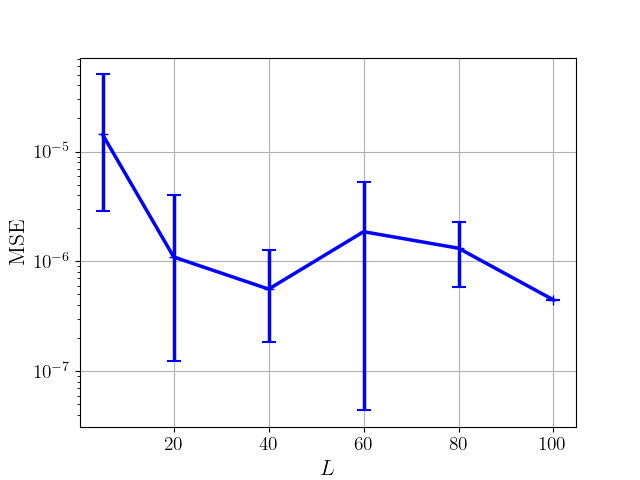

In [39]:
plt.figure()
plt.errorbar(depths, mean_MSE[0,:], error_MSE[0,:], label='batch = 32', color='b', linestyle='-',
             marker='+', capsize=5, capthick=1.5)
#plt.errorbar(depths, mean_MSE[1,:], error_MSE[1,:], label='batch = 64', color='r', linestyle='-',
#             marker='+', capsize=5, capthick=1.5)
#plt.errorbar(depths, mean_MSE[2,:], error_MSE[2,:], label='batch = 128', color='g', linestyle='-',
#             marker='+', capsize=5, capthick=1.5)
plt.yscale('log')
plt.xlabel('$L$')
plt.ylabel('MSE')
plt.legend()
plt.grid()
#plt.savefig('Figures/Deep_depth_study/Deep_depth_study_MSE.pdf', bbox_inches='tight')
plt.show()

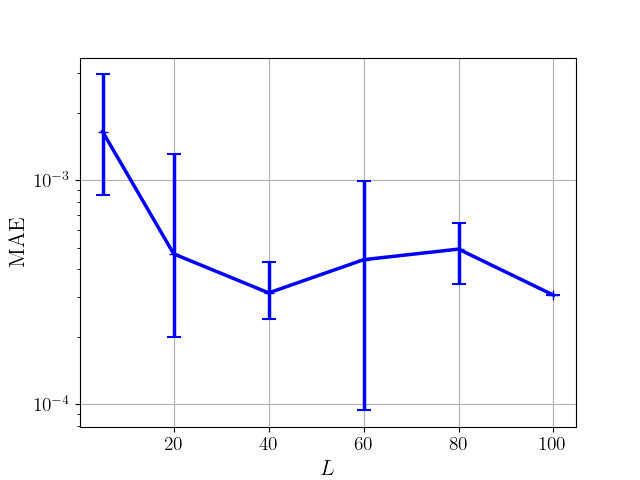

In [40]:
plt.figure()
plt.errorbar(depths, mean_MAE[0,:], error_MAE[0,:], label='batch = 32', color='b', linestyle='-',
             marker='+', capsize=5, capthick=1.5)
#plt.errorbar(depths, mean_MAE[1,:], error_MAE[1,:], label='batch = 64', color='r', linestyle='-',
#             marker='+', capsize=5, capthick=1.5)
#plt.errorbar(depths, mean_MAE[2,:], error_MAE[2,:], label='batch = 128', color='g', linestyle='-',
#             marker='+', capsize=5, capthick=1.5)
plt.yscale('log')
plt.xlabel('$L$')
plt.ylabel('MAE')
plt.legend()
plt.grid()
#plt.savefig('Figures/Deep_depth_study/Deep_depth_study_MAE.pdf', bbox_inches='tight')
plt.show()

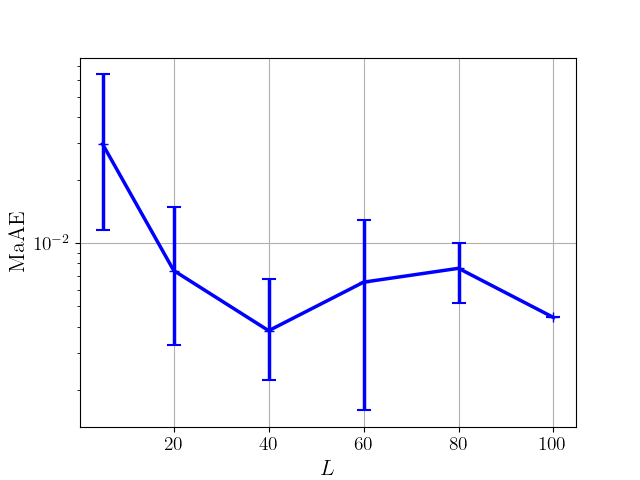

In [42]:
plt.figure()
plt.errorbar(depths, mean_MaAE[0,:], error_MaAE[0,:], label='batch = 32', color='b', linestyle='-',
             marker='+', capsize=5, capthick=1.5)
#plt.errorbar(depths, mean_MaAE[1,:], error_MaAE[1,:], label='batch = 64', color='r', linestyle='-',
#             marker='+', capsize=5, capthick=1.5)
#plt.errorbar(depths, mean_MaAE[2,:], error_MaAE[2,:], label='batch = 128', color='g', linestyle='-',
#             marker='+', capsize=5, capthick=1.5)
plt.yscale('log')
plt.xlabel('$L$')
plt.ylabel('MaAE')
plt.legend()
plt.grid()
#plt.savefig('Figures/Deep_depth_study/Deep_depth_study_MaAE.pdf', bbox_inches='tight')
plt.show()

# Check the results for the best model

In [43]:
name_best = 'Saved_models/Deep_depth_study/batch_32-depth_60-iter_2'
best = keras.models.load_model(name_best)

sorting = np.argsort(features_testing)
features_testing = features_testing[sorting]
labels_testing = labels_testing[sorting]

prediction = best.predict(features_testing)
prediction = np.ravel(prediction)

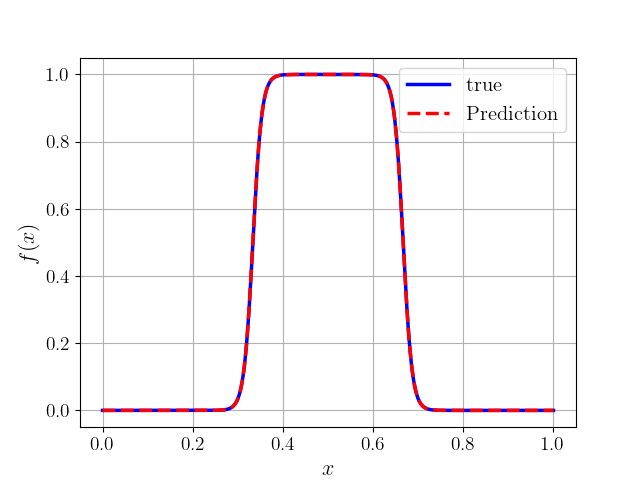

In [45]:
plt.figure()
plt.plot(features_testing, labels_testing, 'b-', label='true')
plt.plot(features_testing, prediction, 'r--', label='Prediction')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend()
plt.grid()
plt.show()

In [64]:
with np.printoptions(formatter={'all':lambda x: f'{x:.4e}'}):
    print(max_MaAE.ravel())

[6.3764e-02 1.4933e-02 6.7692e-03 1.2931e-02 1.0055e-02 4.4238e-03]
